In [38]:
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from keras import layers, models
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import (Input, Dense, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D)
import matplotlib.pyplot as plt
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense


In [51]:
def load_data_pathmnist():
    path = r"C:\Users\clara\Documents\uni\4thYear_AMLS\Datasets\pathmnist.npz"
    #path = r"Datasets\pathmnist.npz"
    with np.load(path) as pathmnistmnist:
        x_train = pathmnistmnist['train_images']
        y_train = pathmnistmnist['train_labels']
        x_val = pathmnistmnist['val_images']
        y_val = pathmnistmnist['val_labels']
        x_test = pathmnistmnist['test_images']
        y_test = pathmnistmnist['test_labels']

    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))

((x_train, y_train), (x_val, y_val), (x_test, y_test)) = load_data_pathmnist()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(89996, 1)
(10004, 1)
(7180, 1)


In [52]:
# Define a dictionary that maps class labels to their names
class_label_names = {
    '0': 'adipose',
    '1': 'background',
    '2': 'debris',
    '3': 'lymphocytes',
    '4': 'mucus',
    '5': 'smooth muscle',
    '6': 'normal colon mucosa',
    '7': 'cancer-associated stroma',
    '8': 'colorectal adenocarcinoma epithelium'
}

# Function to print class label descriptions - this function is called in plot_class_distribution_pathmnist(y_train, y_val, y_test)
# to provide more information about the names of each class
def print_class_label_descriptions(class_label_names):
    print("Class Label Descriptions:")
    for label, name in class_label_names.items():
        print(f"Class {label}: {name}")

Class Label Descriptions:
Class 0: adipose
Class 1: background
Class 2: debris
Class 3: lymphocytes
Class 4: mucus
Class 5: smooth muscle
Class 6: normal colon mucosa
Class 7: cancer-associated stroma
Class 8: colorectal adenocarcinoma epithelium


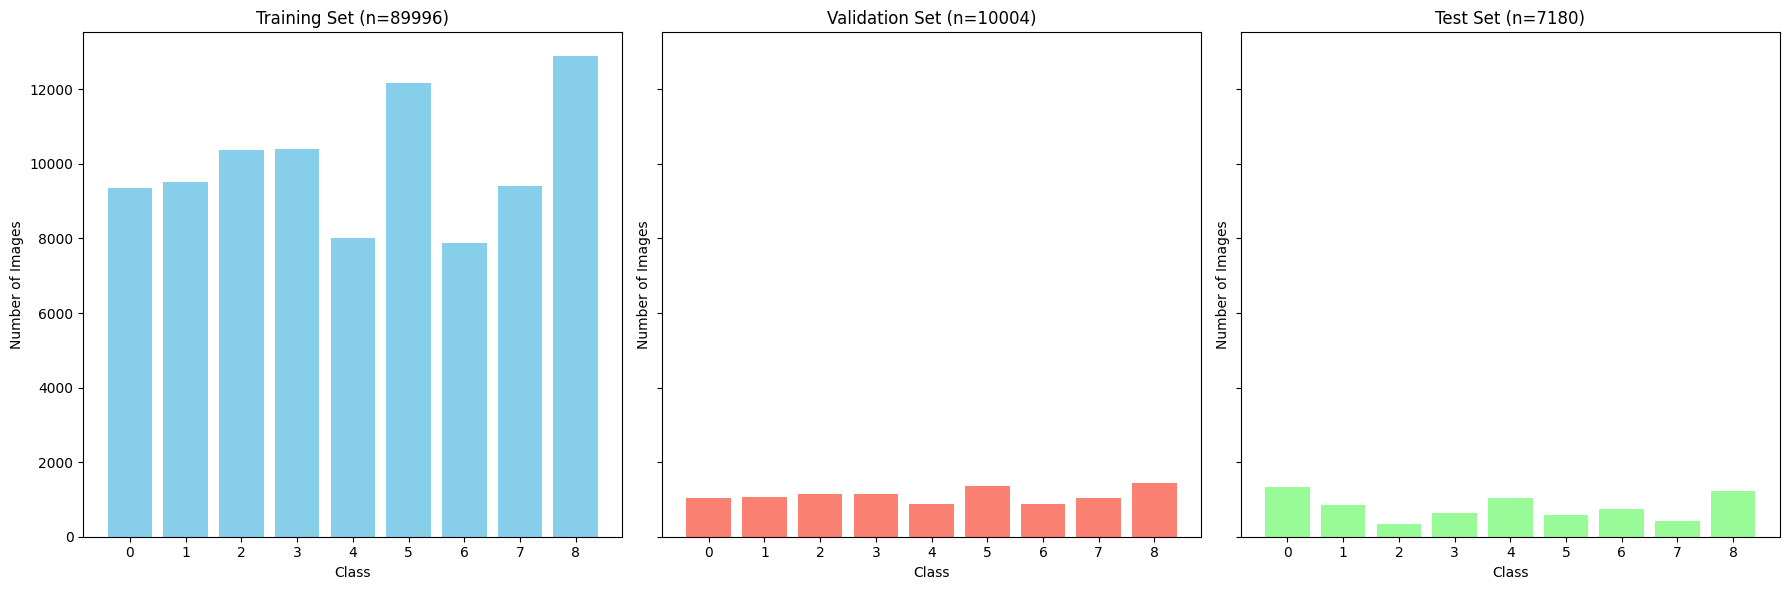

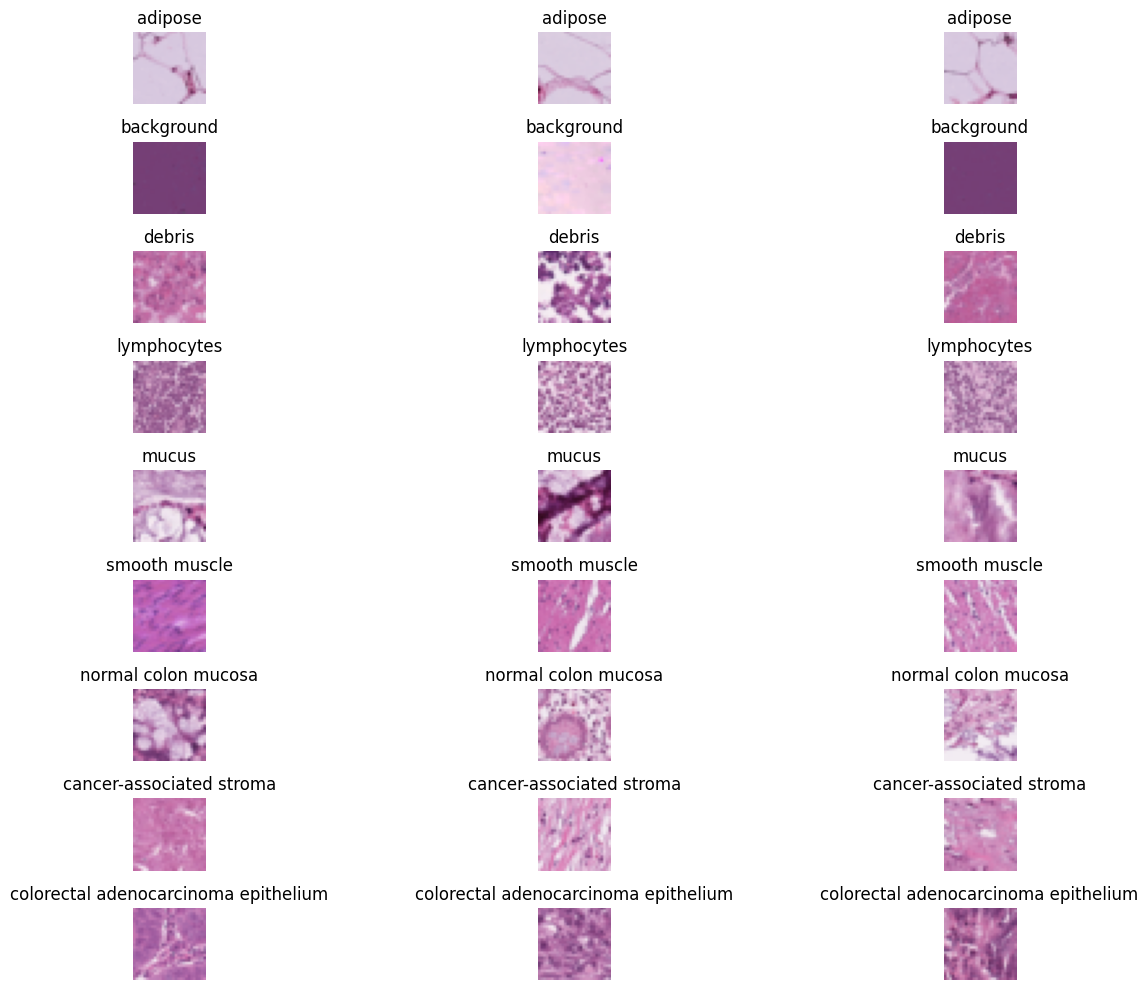

: 

In [53]:
def plot_class_distribution_pathmnist(y_train, y_val, y_test):

    print_class_label_descriptions(class_label_names)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    datasets = [y_train, y_val, y_test]
    titles = ['Training Set', 'Validation Set', 'Test Set']
    colors = ['skyblue', 'salmon', 'palegreen']  

    for i, (dataset, title, color) in enumerate(zip(datasets, titles, colors)):
        classes, counts = np.unique(dataset, return_counts=True)
        axes[i].bar(classes, counts, color=color)
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel('Number of Images')
        axes[i].set_xticks(classes)
        axes[i].set_title(f"{title} (n={len(dataset)})")  # Show the number of samples in the title

    plt.tight_layout()
    plt.show()

plot_class_distribution_pathmnist(y_train, y_val, y_test)
        

def show_sample_images(x_data, y_data, class_label_names, num_samples_per_class=3, num_classes=9):
   
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 10))

    for class_label in range(num_classes):
        class_indices = np.where(y_data == class_label)[0]
        sampled_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        for sample_idx, data_idx in enumerate(sampled_indices):
            image = x_data[data_idx].reshape(28, 28, 3)  # Assuming RGB images
            axes[class_label, sample_idx].imshow(image)
            axes[class_label, sample_idx].axis('off')
            axes[class_label, sample_idx].set_title(class_label_names[str(class_label)])

    plt.tight_layout()
    plt.show()

show_sample_images(x_train, y_train, class_label_names)

In [41]:
def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
    # Normalize images
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val, num_classes=9)
    y_test = to_categorical(y_test, num_classes=9)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Preprocess the data
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

# Check the shapes
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (89996, 9)
y_val shape: (10004, 9)
y_test shape: (7180, 9)


In [42]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with desired augmentations
data_generator = ImageDataGenerator(
    rotation_range=20,        # Degree range for random rotations
    width_shift_range=0.2,    # Range (as a fraction of total width) for horizontal shifts
    height_shift_range=0.2,   # Range (as a fraction of total height) for vertical shifts
    horizontal_flip=True,     # Randomly flip inputs horizontally
    vertical_flip=True,       # Randomly flip inputs vertically
    # You can add more augmentations as needed
)

# Note: Do not apply augmentation to validation or test data
# Assuming x_train, y_train, x_val, y_val are already defined and preprocessed

# Apply augmentation to training data
train_generator = data_generator.flow(x_train, y_train, batch_size=128)

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU

def create_tinyvgg(input_shape, hidden_units, output_shape):
    model = Sequential()
    
    # Conv Block 1
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same', input_shape=input_shape))
    model.add(ReLU())
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=2))
    
    # Conv Block 2
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same'))
    model.add(ReLU())
    model.add(Conv2D(hidden_units, kernel_size=3, strides=1, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=2))

    # Classifier
    model.add(Flatten())
    model.add(Dense(output_shape, activation='softmax'))

    return model

# Create the Keras model
input_shape = (28, 28, 3)  # Replace with your actual input shape
n_classes = 9  # Number of classes
model = create_tinyvgg(input_shape, hidden_units=10, output_shape=n_classes)

# View the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 10)        280       
                                                                 
 re_lu_12 (ReLU)             (None, 28, 28, 10)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 10)        910       
                                                                 
 re_lu_13 (ReLU)             (None, 28, 28, 10)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 10)        910       
                                                      

In [44]:
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
              loss=CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

# Create a model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='./tinyvgg.h5',     # Path where to save the model
    save_best_only=True,         # Save only the best model
    monitor='val_loss',          # Metric to monitor
    mode='min'                   # Save the model with the minimum validation loss
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Add early stopping to the callbacks list
callbacks_list = [model_checkpoint, early_stopping]

# Training with early stopping
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks_list
)



In [45]:
# Training with early stopping
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks_list
)

Epoch 1/50
704/704 [==============================] - 3s 3ms/step - loss: 2.0364 - accuracy: 0.2043 - val_loss: 1.7321 - val_accuracy: 0.3800
Epoch 2/50
704/704 [==============================] - 3s 4ms/step - loss: 1.6078 - accuracy: 0.3982 - val_loss: 1.4953 - val_accuracy: 0.4350
Epoch 3/50
704/704 [==============================] - 2s 3ms/step - loss: 1.2286 - accuracy: 0.5393 - val_loss: 1.0730 - val_accuracy: 0.5886
Epoch 4/50
704/704 [==============================] - 2s 3ms/step - loss: 1.0452 - accuracy: 0.6080 - val_loss: 1.0140 - val_accuracy: 0.6207
Epoch 5/50
704/704 [==============================] - 2s 3ms/step - loss: 0.9670 - accuracy: 0.6397 - val_loss: 1.0679 - val_accuracy: 0.5991
Epoch 6/50
704/704 [==============================] - 2s 3ms/step - loss: 0.9080 - accuracy: 0.6608 - val_loss: 1.0426 - val_accuracy: 0.6076
Epoch 7/50
704/704 [==============================] - 2s 3ms/step - loss: 0.8843 - accuracy: 0.6704 - val_loss: 1.2450 - val_accuracy: 0.5135
Epoch 

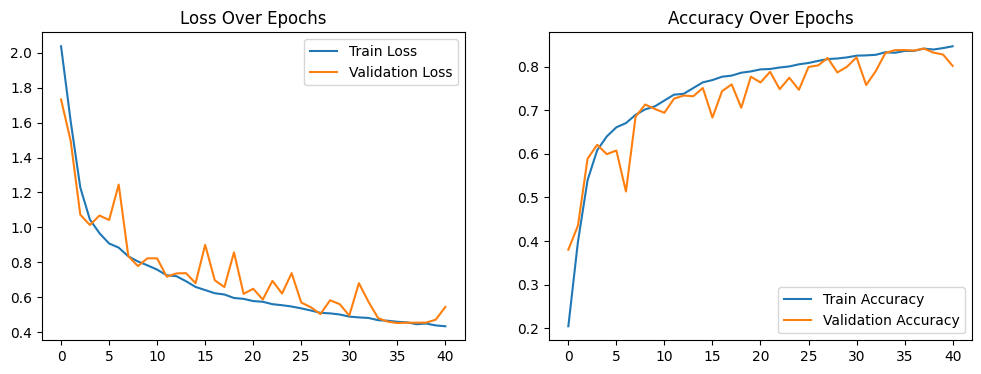

In [46]:
# Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [47]:
# For making predictions
predictions = model.predict(x_test)

# For evaluating the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

225/225 [==============================] - 1s 3ms/step - loss: 0.6567 - accuracy: 0.8056
Test Accuracy: 80.56%


225/225 [==============================] - 1s 3ms/step


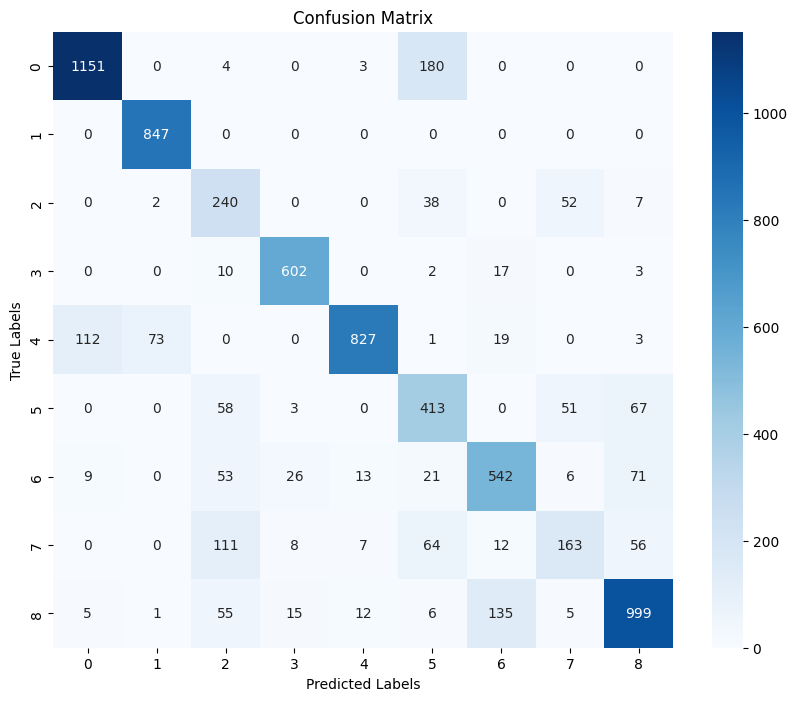

In [49]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Load the trained model
model = load_model('tinyvgg.h5')

# Make predictions on the test data
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
